In [882]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import re

In [883]:
page_reviews = pd.read_json('reviews.json').sort_index()

In [884]:
page_reviews.head()

,Author,Comment(s),Date,Rating,Review,Title
0,Trogdor,,2018-04-08,4.0 out of 5 stars,"FYI, to get it to switch modes, you turn it of...",Obnoxious strobe/flashing mode you can't avoid...
1,Martoman,,2018-04-08,5.0 out of 5 stars,I absolutely LOVE these mini flashlights. They...,A Golden Pair of Mini Flashlights - YOU HAVE T...
2,daniel,,2018-04-08,5.0 out of 5 stars,"Excellent led , portable",Five Stars
3,Däch,,2018-04-08,4.0 out of 5 stars,They are quite bright and seem to be solidly c...,Smaller than they look
4,Heather,,2018-04-08,5.0 out of 5 stars,When I click the button it shines brightly,Five Stars


#### Removing the Regex values before starting any EDA's:

In [885]:
import regex as re
for sentence in page_reviews['Review']:
        sentence=re.sub(u"(\u2018|\u2019)", "'",sentence)

In [886]:
page_reviews[page_reviews['Author']=='Chip Johnson']

,Author,Comment(s),Date,Rating,Review,Title
69,Chip Johnson,One person found this helpful.,2018-02-17,1.0 out of 5 stars,Price is too good to be true. Don’t expect the...,"Faulty, low quality"


In [887]:
%matplotlib inline

#### Getting only the numerical value of the rating and converting to float:

In [888]:
page_reviews['Review']=page_reviews['Review'].apply(lambda x: x.strip('\n'))

In [889]:
page_reviews['Rating'] = page_reviews['Rating'].apply(lambda x: x[:3])

In [890]:
page_reviews['Rating'] = page_reviews['Rating'].apply(lambda x: float(x))

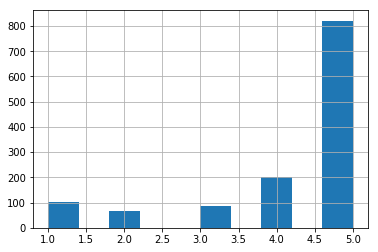

In [891]:
page_reviews['Rating'].hist()

#### Plotting a histogram to see if any seasonality pattern exists

In [892]:
page_reviews['Month']=page_reviews['Date'].dt.month

(array([108.,  73.,  96., 123., 116.,  84., 104.,  77., 131.,  96., 150.,
        122.]),
 array([ 1.        ,  1.91666667,  2.83333333,  3.75      ,  4.66666667,
         5.58333333,  6.5       ,  7.41666667,  8.33333333,  9.25      ,
        10.16666667, 11.08333333, 12.        ]),
 <a list of 12 Patch objects>)

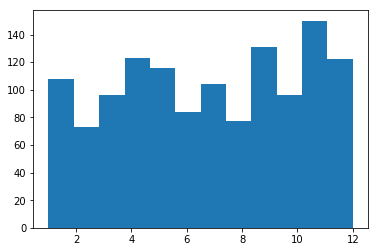

In [893]:
plt.hist(page_reviews['Month'], bins=12)

In [894]:
page_reviews['Month'].value_counts()

11    150
9     131
4     123
12    122
5     116
1     108
7     104
10     96
3      96
6      84
8      77
2      73
Name: Month, dtype: int64

#### Checking to see how the distribution of the reviews is as per the ratings

In [895]:
page_reviews['Review_length'] = page_reviews['Review'].apply(lambda x: len(x))

In [896]:
import seaborn as sns

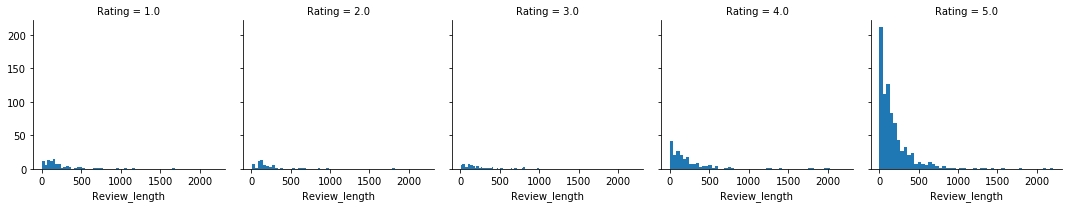

In [897]:
g = sns.FacetGrid(data=page_reviews, col='Rating')
g.map(plt.hist, 'Review_length', bins=50)

#### Creating labels

In [898]:
page_reviews['Class']='class'
page_reviews['Class'][page_reviews['Rating']>3]='High'
page_reviews['Class'][page_reviews['Rating']<=3]='Low'

C:\Users\Akshay\AppData\Local\conda\conda\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Akshay\AppData\Local\conda\conda\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Splitting test and train dataset using stratified sampling so the distribution is even according to the ratings

In [899]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(page_reviews, page_reviews['Rating']):
    strat_train_set = page_reviews.loc[train_index]
    strat_test_set = page_reviews.loc[test_index]

In [900]:
page_rev_label=strat_test_set['Class']
page_rev_test_dat=strat_test_set.drop('Class',axis=1)

In [901]:
page_reviews=strat_train_set.copy()

#### Cleaning the reviews

In [902]:
import spacy
import nltk

In [903]:
nlp = spacy.load('en')

In [904]:
words= set(nltk.corpus.words.words())

In [905]:
stop_words = {'flash', 'flashlight','-PRON-','light','what','other','be','do','not'}
def pre_process_statements(sentences, stop_words=stop_words):
    preprocessed_sentences=[]
    keep_types = {'NOUN', 'ADJ','VERB','ADV'}
    for sentence in sentences:
        doc = nlp(sentence)
        
        if stop_words is not None:
            keep_tokens_string = ' '.join([t.lemma_ for t in doc if t.pos_ in keep_types and t.lemma_ not in stop_words])
        else:
            keep_tokens_string = ' '.join([t.lemma_ for t in doc if t.pos_ in keep_types])
        preprocessed_sentences.append(keep_tokens_string)
    
    return preprocessed_sentences

In [906]:
page_reviews['Review']=pre_process_statements(page_reviews['Review'])

In [907]:
page_reviews['Title']=pre_process_statements(page_reviews['Title'])

In [908]:
page_reviews['Tokenized Sentence'] = page_reviews['Review'].apply(lambda row: nltk.word_tokenize(row))

#### Creating new dataframes for high and low ratings:

In [909]:
page_reviews_low = page_reviews[page_reviews['Rating']<=3]

In [910]:
page_reviews_high = page_reviews[page_reviews['Rating']>3]

In [911]:
from collections import Counter

#### Plotting a word cloud for the two dataframes:

In [913]:
from wordcloud import WordCloud
def wordcloud_plot(lista):
    lista_text = ' '.join(lista)
    wc1 = WordCloud(background_color = "White", max_words = 2000,collocations=True)
    wc1.generate(lista_text)
    plt.imshow(wc1)
    plt.axis('off')
    plt.show()

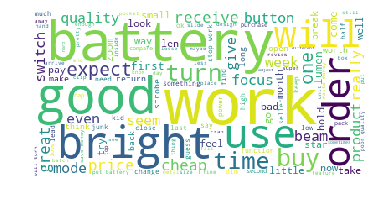

In [914]:
wordcloud_plot(page_reviews_low['Review'])

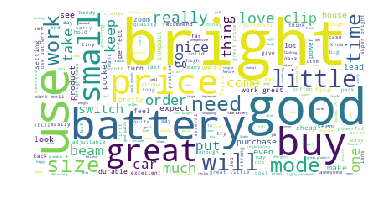

In [915]:
wordcloud_plot(page_reviews_high['Review'])

#### Seeing the number of different authors and how many reviews have they given:

In [984]:
page_reviews['Author'].value_counts()

Amazon Customer      77
John                  4
Chris                 4
Dan                   3
Ron                   3
B                     3
Cliente de Amazon     3
Mike                  3
Aaron                 3
Eric                  3
KC                    2
Mark                  2
Heather               2
Nick                  2
Joe                   2
Jerry                 2
Happy                 2
Tony                  2
Jeremy                2
Walter                2
Karlo                 1
uclafan               1
Kramer                1
James L Bolen         1
Random human          1
R Merten              1
Brent M.              1
Clark Kent            1
WI Farm Family        1
Ray_Larry             1
                     ..
hieuman               1
D. LaMarr             1
Cleve Trevenen        1
Stratto4              1
circuitbored          1
kbn                   1
Harris                1
Chance                1
Bruce Robideau        1
Se'iz Mir Gitt        1
Noel the Pilot  

#### Checking to see if the "Amazon Customer" reviews are not biased:

In [986]:
Counter(" ".join(page_reviews['Review'][page_reviews['Author']=='Amazon Customer']).split()).most_common(10)

[('bright', 22),
 ('great', 21),
 ('very', 20),
 ('have', 20),
 ('battery', 16),
 ('price', 16),
 ('good', 15),
 ('work', 14),
 ('turn', 12),
 ('little', 11)]

In [993]:
rev_amazon_cust = page_reviews['Rating'][page_reviews['Author']=='Amazon Customer']

In [997]:
rev_amazon_cust.head()

212    4.0
780    4.0
817    5.0
469    5.0
218    5.0
Name: Rating, dtype: float64

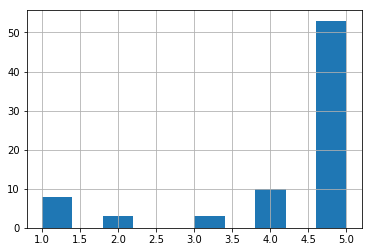

In [996]:
rev_amazon_cust.hist()

#### Creating bigrams for high and low ratings:

In [912]:
import nltk

from nltk import word_tokenize 

from nltk.util import ngrams


def bigrams(doc):
    list_of_b=[]
    for line in doc:
        token =nltk.word_tokenize(line)
        list_of_b.extend(list(ngrams(token,2)))#3 for trigram
    return list_of_b


In [918]:
Counter(" ".join(page_reviews_high['Review']).split()).most_common(10)

[('have', 412),
 ('bright', 409),
 ('battery', 305),
 ('great', 294),
 ('very', 293),
 ('use', 237),
 ('good', 219),
 ('price', 185),
 ('can', 178),
 ('small', 165)]

In [919]:
Counter(" ".join(page_reviews_low['Review']).split()).most_common(10)

[('work', 111),
 ('have', 99),
 ('battery', 84),
 ('good', 59),
 ('get', 54),
 ('bright', 53),
 ('would', 46),
 ('very', 45),
 ('will', 45),
 ('use', 44)]

In [920]:
Counter(" ".join(page_reviews_high['Title']).split()).most_common(10)

[('star', 204),
 ('great', 144),
 ('bright', 98),
 ('good', 80),
 ('little', 64),
 ('very', 57),
 ('price', 53),
 ('small', 42),
 ('nice', 31),
 ('have', 28)]

In [921]:
Counter(" ".join(page_reviews_low['Title']).split()).most_common(10)

[('star', 32),
 ('work', 17),
 ('quality', 14),
 ('good', 12),
 ('bright', 11),
 ('buy', 11),
 ('have', 10),
 ('great', 9),
 ('get', 8),
 ('bad', 8)]

#### Splitting the variables and labels of the test data

In [922]:
reviews_label=page_reviews['Class'].copy()
page_reviews=page_reviews.drop('Class',axis=1)

#### Confirming the same

In [923]:
page_reviews.head()

,Author,Comment(s),Date,Rating,Review,Title,Month,Review_length,Tokenized Sentence
1108,eugef,One person found this helpful.,2013-03-08,3.0,take while get door however worth wait solid p...,solid beware seller,3,476,"[take, while, get, door, however, worth, wait,..."
1029,Gerard W Salvia,One person found this helpful.,2013-07-11,5.0,great handy work just have glove box use daily...,awesome,7,111,"[great, handy, work, just, have, glove, box, u..."
128,diesel,2 people found this helpful.,2017-12-23,1.0,could give product zero would absolutely terri...,absolutely terrible trash have yet work properly,12,168,"[could, give, product, zero, would, absolutely..."
212,Amazon Customer,,2017-10-31,4.0,handy know how long battery last yet still too...,good product,10,74,"[handy, know, how, long, battery, last, yet, s..."
1012,tom,,2013-08-26,5.0,really impressed give small size adjustable ca...,,8,477,"[really, impressed, give, small, size, adjusta..."


#### Creating a custom transformer for cleaning the reviews

In [924]:
from sklearn.base import BaseEstimator, TransformerMixin

In [925]:
class PreProcessor(BaseEstimator,TransformerMixin):
    def __init__(self, pos_to_keep=('NOUN', 'ADJ', 'VERB','ADV'), stop_words=None):
        self.pos_to_keep = pos_to_keep
        self.stop_words = stop_words
        
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        preprocessed_sentences = []
        
        for doc in nlp.pipe(X, n_threads=8):
            if self.stop_words is not None:
                keep_tokens_string = ' '.join([t.lemma_ for t in doc if t.pos_ in self.pos_to_keep and t.lemma_ not in self.stop_words])
            else:
                keep_tokens_string = ' '.join([t.lemma_ for t in doc if t.pos_ in self.pos_to_keep])
            preprocessed_sentences.append(keep_tokens_string)
    
        return preprocessed_sentences

#### Using SMOTE to oversample with "SVM" algorithm

In [926]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=42)

#### Creating a pipeline for doing logistoc regression and checking the accuracy of the same

In [927]:
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
text_clf = Pipeline([('prep',PreProcessor(stop_words=stop_words)),
                     ('vect', CountVectorizer(ngram_range=(1,1))),
                     ('tfidf', TfidfTransformer()),
                     ('smt',SMOTE(random_state=42,k_neighbors=5,kind='svm')),
                     ('lr', LogisticRegression(C=0.8))
                    ])

In [928]:
text_clf.fit(page_reviews['Review'],reviews_label)

Pipeline(memory=None,
     steps=[('prep', PreProcessor(pos_to_keep=('NOUN', 'ADJ', 'VERB', 'ADV'),
       stop_words={'-PRON-', 'not', 'what', 'light', 'be', 'do', 'flashlight', 'flash', 'other'})), ('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='u...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [929]:
import numpy as np
predicted = text_clf.predict(page_rev_test_dat['Review'])
np.mean(predicted==page_rev_label)


0.86328125

#### Creating a pipeline for random forest and checking the accuracy on test data

In [969]:
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
class_weights=[{1:1},{2:4},{3:1},{4:1},{5:7},{6:2},{7:1},{8:1},{9:1},{10:4}]
text_sgd = Pipeline([('prep',PreProcessor(stop_words=stop_words)),
                     ('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('ros',SMOTE(random_state=42)),
                     ('rfc',RandomForestClassifier(n_estimators=20,random_state=4))
                    ])

In [970]:
from sklearn.pipeline import FeatureUnion

In [971]:
text_sgd.fit(page_reviews['Review'],reviews_label)

Pipeline(memory=None,
     steps=[('prep', PreProcessor(pos_to_keep=('NOUN', 'ADJ', 'VERB', 'ADV'),
       stop_words={'-PRON-', 'not', 'what', 'light', 'be', 'do', 'flashlight', 'flash', 'other'})), ('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='u...estimators=20, n_jobs=1,
            oob_score=False, random_state=4, verbose=0, warm_start=False))])

In [972]:
pipe_rf = text_sgd.named_steps['rfc']

In [973]:
import numpy as np
predicted = text_sgd.predict(page_rev_test_dat['Review'])
np.mean(predicted==page_rev_label)


0.8515625

#### From the above assignment, I believe that Logistic Regression has a higher accuracy in terms of predicting the rating depending upon the words used in the reviews. It may so happen that for another dataset, the accuracy may not remain the same. Considering we have limited amount of sample points in this dataset, we are left with no alternative but to choose Logistic Regression as our go to estimator.